## SQL (Airbnb)

Анализ датасета (ldn_listings), содержащего информацию об объявлениях на Airbnb в Лондоне.

1. Выведите количество строк в таблице.  
2. Выгрузите из таблицы данные о цене в зависимости от типа жилья. Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id. Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.  
3. К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32. Сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга. Постройте график рассеивания средней цены и рейтинга c разбивкой по типу жилья.
4. Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Посчитайте, сколько раз встречается каждый способ верификации.
5. Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap().  
6. Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Постройте два графика:  
на первом отобразите исходные распределения цен для каждого типа жилья;  
на втором – логарифмированные значения.   
7. Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Ограничение поставьте на 1000 строк. Постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам. Датафрейм должен быть отсортирован по годам.

In [1]:
# импортируем библиотеки

import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# создаем словарь connection с нужными параметрами

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### 1. Выведите количество строк в таблице.

In [3]:
# создаем запрос
q = '''
    SELECT 
        count() 
    FROM 
        {db}.ldn_listings
    '''

In [4]:
# отправляем запрос и записываем результат в пандасовский датафрейм

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


### 2. Выгрузите из таблицы данные о цене в зависимости от типа жилья. Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id. Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [5]:
# создаем запрос

q1 = '''
   SELECT id,
        (toFloat64OrNull(replaceRegexpAll(price, '[$,]', ''))) as price,
        room_type
    FROM 
        ldn_listings
    ORDER BY id
    LIMIT 1000
    '''

In [6]:
# выгружаем датафрейм

q_test1 = ph.read_clickhouse(query=q1, connection=connection_default)
q_test1.head()

,id,price,room_type
0,13913,65.0,Private room
1,15400,100.0,Entire home/apt
2,17402,300.0,Entire home/apt
3,17506,150.0,Private room
4,25023,65.0,Entire home/apt


In [7]:
# группируем по типу жилья и считаем 75-ый перцентиль цены

q_test1.groupby('room_type', as_index = False) \
        .quantile(q=0.75)

,room_type,id,price
0,Entire home/apt,463610.50,160.00
1,Hotel room,73302.50,157.00
2,Private room,453442.50,70.00
3,Shared room,472261.75,69.25


### 3. К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32. Сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга. Постройте график рассеивания средней цены и рейтинга c разбивкой по типу жилья.

In [8]:
# создаем запрос

q2 = '''
   SELECT id,
        (toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) as price,
       toFloat32OrNull(review_scores_rating) as rating,
       room_type
    FROM 
        ldn_listings
    WHERE rating > 0
    ORDER BY id
    LIMIT 1000
    '''

In [9]:
# выгружаем датафрейм

q_test2 = ph.read_clickhouse(query=q2, connection=connection_default)
q_test2.head()

,id,price,rating,room_type
0,13913,65.0,97.0,Private room
1,15400,100.0,96.0,Entire home/apt
2,17402,300.0,94.0,Entire home/apt
3,25023,65.0,93.0,Entire home/apt
4,25123,29.0,96.0,Private room


In [10]:
# группируем датафрейм по типу жилья и считаем среднее для цены и рейтинга

q_test2_group = q_test2.groupby('room_type', as_index = False) \
    .mean()

q_test2_group 

,room_type,id,price,rating
0,Entire home/apt,384903.108830,135.882950,93.568787
1,Hotel room,65525.000000,134.000000,92.500000
2,Private room,383590.166994,54.642437,94.766205
3,Shared room,474893.500000,21.000000,90.000000


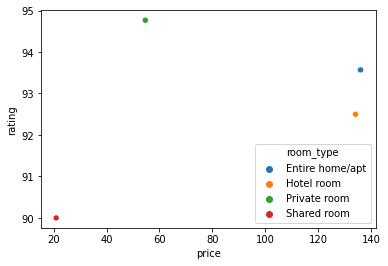

In [11]:
# cтроим график рассеивания средней цены и рейтинга c разбивкой по типу жилья

sns.scatterplot(data = q_test2_group, x = 'price', y = 'rating' , hue = 'room_type')

### 4. Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Посчитайте, сколько раз встречается каждый способ верификации.

In [12]:
# создаем запрос

q3 = '''
   SELECT DISTINCT host_id,
                   host_verifications
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    ORDER BY id
    '''

In [13]:
# выгружаем датафрейм

q_test3 = ph.read_clickhouse(query=q3, connection=connection_default)
q_test3.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [14]:
# создаем список из способов верификации для каждого id

q_test3['host_verifications'] = q_test3.host_verifications.apply(lambda x: x.strip('[]').replace("'",'').split(', '))
q_test3.head()

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."


In [15]:
# считаем, сколько раз встречается каждый способ верификации

q_test3.explode('host_verifications').host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

### 5. Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap().

In [16]:
# создаем запрос

q4 = '''
   SELECT  neighbourhood_cleansed,
           experiences_offered,
           count(neighbourhood_cleansed) as experiences_count
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, 
            experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''

In [17]:
# выгружаем датафрейм

q_test4 = ph.read_clickhouse(query=q4, connection=connection_default)
q_test4.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [18]:
# преобразуем данные

q_test4_table = q_test4 \
                .pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count') \
                .fillna(0)

q_test4_table.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0


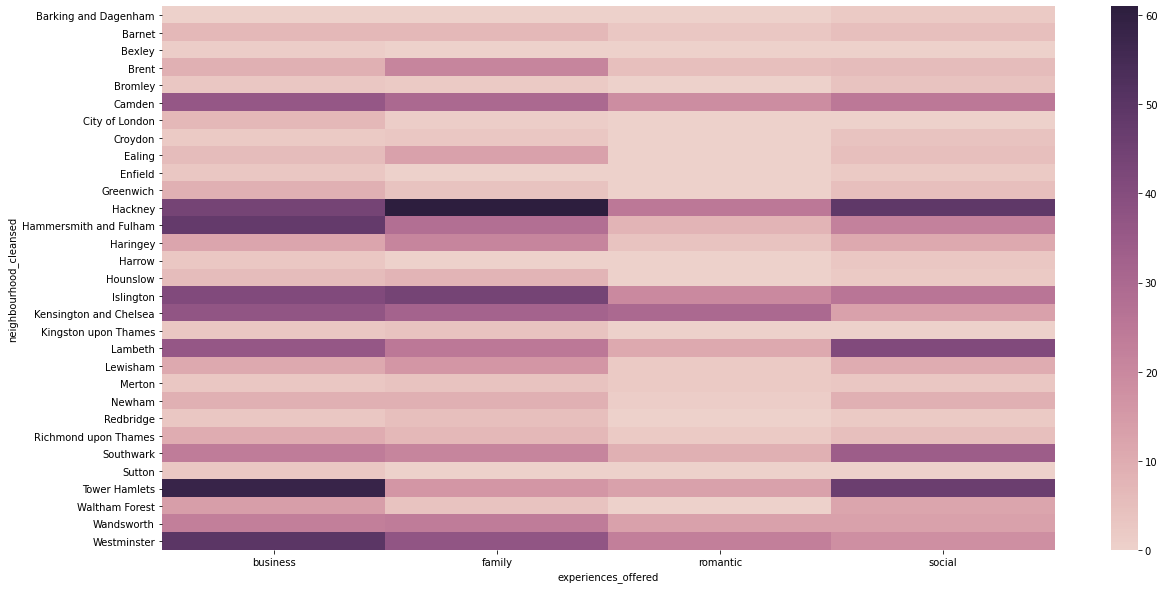

In [19]:
# визуализируем результат

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(q_test4_table, cmap=sns.cubehelix_palette(as_cmap=True))

### 6. Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Постройте два графика: на первом отобразите исходные распределения цен для каждого типа жилья, на втором – логарифмированные значения.

In [20]:
# создаем запрос

q5 = '''
   SELECT 
        room_type,
        (toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) as price
    FROM 
        ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY room_type, price
    LIMIT 1000
    '''

In [21]:
# выгружаем датафрейм

q_test5 = ph.read_clickhouse(query=q5, connection=connection_default)
q_test5.head()

,room_type,price
0,Entire home/apt,89.0
1,Private room,93.0
2,Entire home/apt,157.0
3,Entire home/apt,70.0
4,Private room,66.0


In [22]:
# посмотрим, какие типы жилья есть в столбце room_type

q_test5.room_type.value_counts()

Entire home/apt    187
Private room        94
Shared room          8
Hotel room           3
Name: room_type, dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


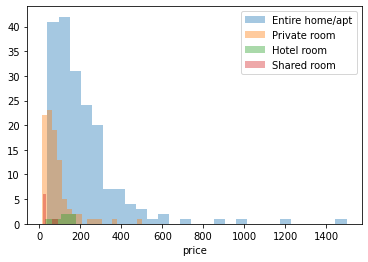

In [23]:
# визуализируем исходные распределения цен для каждого типа жилья

sns.distplot(q_test5.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(q_test5.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(q_test5.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(q_test5.query("room_type=='Shared room'").price, kde=False, label='Shared room')

plt.legend()
plt.show()

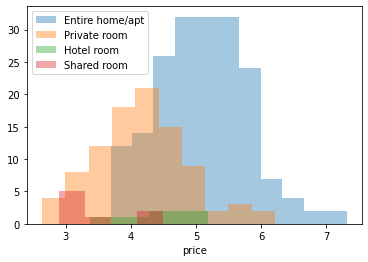

In [24]:
# визуализируем логарифмированные распределения цен для каждого типа жилья

sns.distplot(np.log(q_test5.query("room_type =='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_test5.query("room_type =='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(q_test5.query("room_type =='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(q_test5.query("room_type =='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

### 7. Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Ограничение поставьте на 1000 строк. Постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам. Датафрейм должен быть отсортирован по годам.

In [25]:
# создаем запрос

q6 = '''
   SELECT 
        room_type,
        (toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))) as price,
        first_review
    FROM 
        ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''

In [26]:
# выгружаем датафрейм

q_test6 = ph.read_clickhouse(query=q6, connection=connection_default)
q_test6.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [27]:
# делим на элементы по знаку "-" и оставляемтолько нулевой элемент, т.е. год

q_test6['first_review'] = q_test6.first_review.apply(lambda x: x.split('-')[0])
q_test6.head()

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


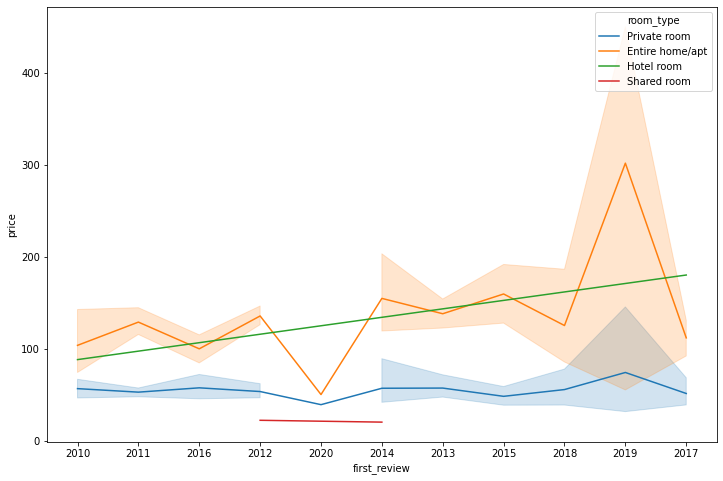

In [28]:
# строим график динамики средних цен на жилье в зависимости от типа комнаты по годам

plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=q_test6)